In [50]:
# Importing libraries 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import random
import itertools
from sklearn.metrics import confusion_matrix
from skimage.segmentation import mark_boundaries


In [2]:
#  Setting up the device that will be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


Conversion des fichiers en fichiers 2D


In [4]:
# Code pour convertir les fichiers en bon format.
''''
# Dossiers d'entrée et de sortie
input_folder = 'CHAOS-MRT2'  # Chemin vers votre dossier avec les fichiers NIfTI
output_folder = 'CHAOS-MRT2-NORMALIZED'     # Chemin vers le dossier de sortie

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Fonction pour normaliser les fichiers sources
def normalize_image(image_array):
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Fonction pour convertir les masques en classes entières
def convert_mask(mask_array):
    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)
    mask_array_int[mask_array == 0] = 0  # Arrière-plan
    mask_array_int[mask_array == 80] = 1  # Classe 1
    mask_array_int[mask_array == 160] = 2  # Classe 2
    mask_array_int[mask_array == 240] = 3  # Classe 3
    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)
    return mask_array_int

# Parcourir tous les fichiers du dossier
for filename in os.listdir(input_folder):
    if filename.endswith('-src.nii.gz'):  # Fichier source (image)
        # Charger le fichier source
        src_path = os.path.join(input_folder, filename)
        src_img = nib.load(src_path)
        src_array = src_img.get_fdata()

        # Normaliser l'image A voir s'il faut le garder.
        src_array_norm = normalize_image(src_array).astype(np.float32)

        # Sauvegarder l'image normalisée
        output_path = os.path.join(output_folder, filename)
        new_src_img = nib.Nifti1Image(src_array_norm, affine=src_img.affine)
        nib.save(new_src_img, output_path)
        print(f"Image source normalisée sauvegardée : {output_path}")

    elif filename.endswith('-mask.nii.gz'):  # Fichier masque
        # Charger le fichier masque
        mask_path = os.path.join(input_folder, filename)
        mask_img = nib.load(mask_path)
        mask_array = mask_img.get_fdata()

        # Convertir les masques en classes entières
        mask_array_int = convert_mask(mask_array)

        # Sauvegarder le masque converti
        output_path = os.path.join(output_folder, filename)
        new_mask_img = nib.Nifti1Image(mask_array_int, affine=mask_img.affine)
        nib.save(new_mask_img, output_path)
        print(f"Masque converti sauvegardé : {output_path}")
'''

'\'\n# Dossiers d\'entrée et de sortie\ninput_folder = \'CHAOS-MRT2\'  # Chemin vers votre dossier avec les fichiers NIfTI\noutput_folder = \'CHAOS-MRT2-NORMALIZED\'     # Chemin vers le dossier de sortie\n\n# Créer le dossier de sortie s\'il n\'existe pas\nif not os.path.exists(output_folder):\n    os.makedirs(output_folder)\n\n# Fonction pour normaliser les fichiers sources\ndef normalize_image(image_array):\n    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))\n\n# Fonction pour convertir les masques en classes entières\ndef convert_mask(mask_array):\n    mask_array_int = np.zeros_like(mask_array, dtype=np.uint8)\n    mask_array_int[mask_array == 0] = 0  # Arrière-plan\n    mask_array_int[mask_array == 80] = 1  # Classe 1\n    mask_array_int[mask_array == 160] = 2  # Classe 2\n    mask_array_int[mask_array == 240] = 3  # Classe 3\n    mask_array_int[mask_array == 255] = 4  # Classe 4 (à vérifier)\n    return mask_array_int\n\n# Parcourir tous 

Visualisation de fichiers crées


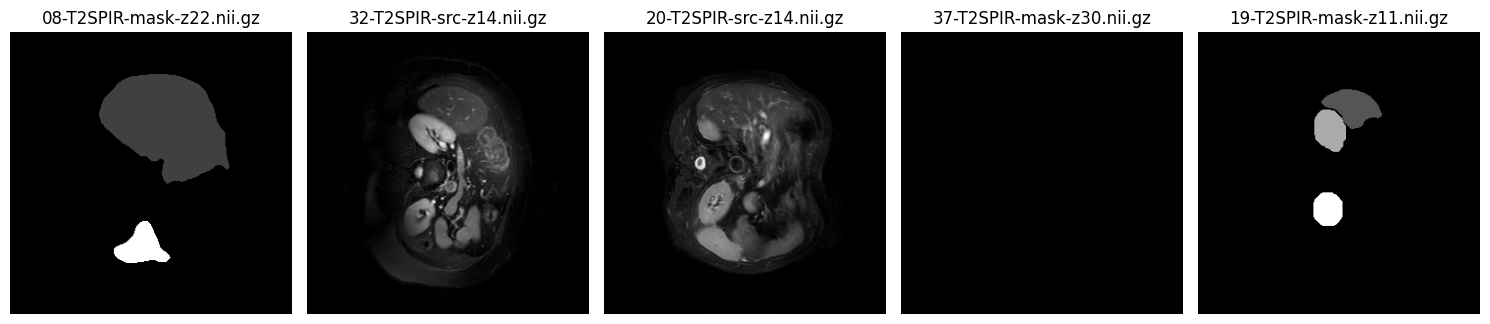

In [3]:
# Dossier contenant les images 2D
folder_path = 'CHAOS-MRT2-2D-NORMALIZED'

# Charger et afficher quelques images
def display_images(folder_path, num_images=5):
    files = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]
    selected_files = files[:num_images]  # Prendre les premières `num_images` fichiers
    
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(selected_files):
        file_path = os.path.join(folder_path, filename)
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Afficher l'image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_data, cmap='gray')
        plt.title(filename)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les images
display_images(folder_path)


Création des loaders

In [3]:
# Chemin vers le dossier contenant les fichiers 2D créés
chaos_dir = 'CHAOS-MRT2-2D-NORMALIZED'

# Récupérer tous les fichiers source et masque 2D
all_src_files = sorted(glob.glob(os.path.join(chaos_dir, '*-src-z*.nii.gz')))
all_mask_files = sorted(glob.glob(os.path.join(chaos_dir, '*-mask-z*.nii.gz')))

# Vérification de la correspondance des fichiers source et masque
assert len(all_src_files) == len(all_mask_files), "Le nombre de fichiers source et masque ne correspond pas!"

# Taille cible (à adapter selon vos besoins)
target_shape = (256, 256)  # Pour les images 2D

# Définition du Dataset personnalisé
class LazyNii2DDataset(Dataset):
    def __init__(self, src_files, mask_files, target_shape):
        self.src_files = src_files
        self.mask_files = mask_files
        self.target_shape = target_shape

    def __len__(self):
        return len(self.src_files)

    def __getitem__(self, idx):
        # Charger le fichier source et le fichier masque
        src_tensor = self.load_and_resize(self.src_files[idx])
        mask_tensor = self.load_and_resize(self.mask_files[idx])
        
        # Ajouter la dimension du canal
        src_tensor = src_tensor.unsqueeze(0)  # (1, H, W) pour les données
        mask_tensor = mask_tensor.unsqueeze(0)  # (1, H, W) pour les masques, si besoin

        return src_tensor, mask_tensor

    def load_and_resize(self, file_path):
        nii = nib.load(file_path)
        img_data = nii.get_fdata()
        tensor_data = torch.tensor(img_data, dtype=torch.float32)

        # Ajouter la dimension channel et redimensionner à la taille cible
        tensor_data = tensor_data.unsqueeze(0)  # Ajouter la dimension channel
        resized_tensor = F.interpolate(tensor_data.unsqueeze(0), size=self.target_shape, mode='bilinear', align_corners=False)
        return resized_tensor.squeeze()  # Supprimer la dimension batch

# Division des données en ensembles d'entraînement, validation et test
train_src, temp_src, train_mask, temp_mask = train_test_split(all_src_files, all_mask_files, test_size=0.2, random_state=42)
val_prop = 0.5  # Pour séparer temp en validation et test
val_src, test_src, val_mask, test_mask = train_test_split(temp_src, temp_mask, test_size=val_prop, random_state=42)

# Créer les datasets
train_dataset = LazyNii2DDataset(train_src, train_mask, target_shape)
val_dataset = LazyNii2DDataset(val_src, val_mask, target_shape)
test_dataset = LazyNii2DDataset(test_src, test_mask, target_shape)

# Créer les DataLoaders
batch_size = 1  # Taille de batch typique pour un U-Net 2D classique avec cpu
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Afficher la forme d'un batch pour vérifier
for x, y in train_loader:
    print(f'Batch X shape: {x.shape}, Batch Y shape: {y.shape}')
    break


Batch X shape: torch.Size([1, 1, 256, 256]), Batch Y shape: torch.Size([1, 1, 256, 256])


In [133]:
class UNet2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=5):
        super(UNet2d, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Optionnel, à tester selon les besoins

        # Contracting path
        self.enc1 = self.contract_block(in_channels, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)

        # Bottleneck
        self.bottleneck = self.contract_block(512, 1024)

        # Expanding path
        self.dec4 = self.expand_block(1024 + 512, 512)
        self.dec3 = self.expand_block(512 + 256, 256)
        self.dec2 = self.expand_block(256 + 128, 128)
        self.dec1 = self.expand_block(128 + 64, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_concat(self, x1, x2):
        # Redimensionner x1 pour qu'il corresponde à la taille de x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=True)
        return torch.cat([x1, x2], dim=1)

    def forward(self, x):
        # Encode
        enc1 = self.enc1(x)
        enc1_pool = self.maxpool(enc1)

        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.maxpool(enc2)

        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.maxpool(enc3)

        enc4 = self.enc4(enc3_pool)
        enc4_pool = self.maxpool(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)

        # Decode
        dec4 = self.up_concat(bottleneck, enc4)
        dec4 = self.dec4(dec4)

        dec3 = self.up_concat(dec4, enc3)
        dec3 = self.dec3(dec3)

        dec2 = self.up_concat(dec3, enc2)
        dec2 = self.dec2(dec2)

        dec1 = self.up_concat(dec2, enc1)
        dec1 = self.dec1(dec1)

        # Redimensionner la sortie finale à 256x256
        dec1 = F.interpolate(dec1, size=(256, 256), mode='bilinear', align_corners=True)

        return self.final_conv(dec1)

# Créer l'instance du modèle
model = UNet2d()
model.to(device)
# Summary of the model
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Training

In [5]:
# critère qui est une combinaison de dice loss et cross entropie. Peut etre interessant à utiliser.
# à essayer
"""def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)  # Si activation sigmoid utilisée pour la sortie
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def combined_loss(pred, target):
    ce_loss = F.cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    return ce_loss + dice"""
# Poids Egaux à l'inverse des fréquences des classes.
class_weights = torch.tensor([1.04, 30.3, 263.1, 158.7, 270.3])  

# Appliquer la pondération dans la perte
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Entrainement normal

In [84]:
# Load the weights saved 
checkpoint_path = 'EssaisClassique2D/weightsepoque47.pth'
model.load_state_dict(torch.load(checkpoint_path))

/tmp/ipykernel_755/2230948990.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


<All keys matched successfully>

In [85]:
n_epochs = 15  # nombre d'époques d'entraînement

# Fonction d'entraînement modifiée
def training(model, criterion, optimizer, train_loader, val_loader,device):
    numberSamples = len(train_loader.dataset)
    train_losses, valid_losses = [], []
    valid_loss_min = 0.08760393239208497
    i = 1
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0

        # Entraînement
        model.train()
        for data, label in train_loader:
            data = data.to(device)  # Ajouter la dimension des canaux
            label = label.squeeze(1).to(device).long()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            print(epoch,i,":",train_loss)
            i += 1
            

        # Validation
        model.eval()
        for data, label in val_loader:
            data = data.to(device)  # Ajouter la dimension des canaux
            label = label.squeeze(1).to(device).long()

            with torch.no_grad():
                output = model(data)
            loss = criterion(output, label)
            valid_loss += loss.item() * data.size(0)

        # Calcul des pertes moyennes
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

        # Sauvegarder le modèle si la perte de validation a diminué
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), 'modelUnetClassique.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses


# Exécuter l'entraînement


In [86]:
train_losses, valid_losses = training(model, criterion, optimizer, train_loader, val_loader,device)


0 1 : 0.09983724355697632
0 2 : 0.12300603836774826
0 3 : 0.12312508262402844
0 4 : 0.14062259606726002
0 5 : 0.30705210081941914
0 6 : 0.3269934270501835
0 7 : 0.48152353502518963
0 8 : 0.631805798780988
0 9 : 0.6588383845955832
0 10 : 0.6814440607995493
0 11 : 0.8416727304429514
0 12 : 0.8583037003845675
0 13 : 1.0141470774979098
0 14 : 1.1880126044125063
0 15 : 1.2032245824084384
0 16 : 1.2331241497740848
0 17 : 1.233195415334194
0 18 : 1.2575017890048912
0 19 : 1.3308107337070396
0 20 : 1.4728815784765175
0 21 : 1.4893992865545442
0 22 : 1.4895344368705992
0 23 : 1.5128697689215187
0 24 : 1.5490387241879944
0 25 : 1.5729359101096634
0 26 : 1.5763126235979144
0 27 : 1.608115393348271
0 28 : 1.6374241091834847
0 29 : 1.637999445461901
0 30 : 1.6613006929692347
0 31 : 1.6710838724684436
0 32 : 1.7459659327578265
0 33 : 1.7587392127898056
0 34 : 1.772030601539882
0 35 : 1.9015727883961517
0 36 : 1.9386546856549103
0 37 : 1.9579248561349232
0 38 : 2.0790026097383816
0 39 : 5.35328887987

KeyboardInterrupt: 

In [44]:
print(train_losses)
print(valid_losses)
#Sauvegarde des poids du modèle : 
# Chemin où tu veux sauvegarder les poids (par exemple, dans un fichier .pth)
checkpoint_weights_path = 'EssaisClassique2D/weightsepoque62.pth'

# Sauvegarder les poids du modèle
torch.save(model.state_dict(), checkpoint_weights_path)
print(f"Model weights saved in  {checkpoint_weights_path}")

#Sauvegarde de tous le modèle : 
# Sauvegarder tout le modèle (pas uniquement les poids)
checkpoint_model_path = 'EssaisClassique2D/fullmodelepoque62.pth'
torch.save(model, checkpoint_model_path)
print(f"Model saved in {checkpoint_model_path}")

# Charger tout le modèle
#model = torch.load('full_model.pth')
#model.eval()  # Ne pas oublier de passer en mode évaluation pour les prédictions


[0.04192188574306211, 0.040768706239877245, 0.047877746627122915, 0.14921970227575634, 0.06874816628017223]
[0.09147483565267699, 0.11704485601225993, 0.13496528969982924, 0.1501675507574642, 0.10934971277286315]
Model weights saved in  EssaisClassique2D/weightsepoque47.pth
Model saved in EssaisClassique2D/fullmodelepoque42.pth


57
57


Text(0, 0.5, 'loss value')

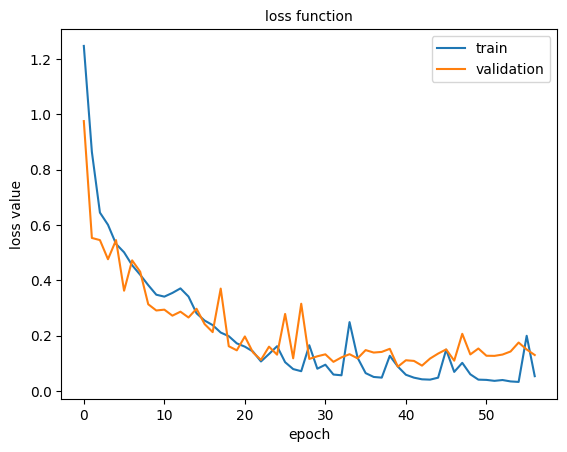

In [87]:

a=[1.2478474983409333, 0.8644760777441058, 0.644944504284159, 0.6008773155358763, 0.5317051793520114,0.5012616208361486, 0.45458815847960377,0.42000485671215504, 0.38259985283769765, 0.3479600523925895, 0.3410081232069874, 0.3543784943710107,0.3708386219926734, 0.3412885210627423, 0.2807044186899915, 0.2544968673459955, 0.2380751507400946, 0.21108488557236726, 0.1980208102385325, 0.17192247313068015, 0.16006387815649895, 0.1425918656592962,0.1064704871646611, 0.13346876610760022, 0.16164293544171668, 0.10386688187924104, 0.07894442566492814,0.07126364956383031, 0.16526162143150852, 0.08028131396503999, 0.09478021157762237, 0.0591885053673012,0.05649422136097732, 0.24889996955975074, 0.1198772251142312, 0.06433981611973111, 0.0504854109498961,0.04803862735618191, 0.12700702300663252, 0.08795941596240782, 0.058397917131844654, 0.047916182318117645,0.04192188574306211, 0.040768706239877245, 0.047877746627122915, 0.14921970227575634, 0.06874816628017223,0.101544,0.060093,0.040756,0.039856,0.036392,0.039361,0.034291,0.032504,0.199427,0.053262]


b=[0.9759773407447137, 0.5532452923766638, 0.5455141304913214, 0.47623610496520996, 0.5454868838443594,0.3624002698619487, 0.47222638433262454,0.43108788157923744, 0.31335310991537774, 0.2909346426189956, 0.2939060522338091, 0.2721872127662271,0.28654098021403207, 0.2655692667526714, 0.2970656425518505, 0.2417998246343459, 0.21260389388870385, 0.3700452784107903, 0.16164126139828713, 0.1467906624962718, 0.19694516391067182, 0.1395359910014322,0.11225060262654166, 0.16004436527836627, 0.13110608721183517, 0.278492798997184, 0.11794022220518377,0.31530128072126434, 0.11566447637091248, 0.12520661563375743, 0.13233484141528606, 0.10513722212093299,0.12130668579222895, 0.13279058418031467, 0.11775969342975798, 0.1476006563239873, 0.13869700028047546,0.14107539150291676, 0.15221512699657577, 0.08760393239208497, 0.11085281581657355, 0.10851284635985287,0.09147483565267699, 0.11704485601225993, 0.13496528969982924, 0.1501675507574642, 0.10934971277286315,0.206537,0.131901,0.153371,0.127208,0.126740,0.131478,0.142582,0.174924,0.149865,0.129811]


print(len(a))
print(len(b))



plt.plot(range(len(a)), a)
plt.plot(range(len(b)), b)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


Evaluation du modèle

In [46]:
def evaluation(model, val_loader, criterion, device, num_classes=5):
    val_loss = 0.0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    model.eval()  # Mettre le modèle en mode évaluation
    for data, label in val_loader:
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long).squeeze(1)  # Suppression de la dimension de canal si nécessaire

        with torch.no_grad():
            output = model(data)

        # Calcul de la perte
        loss = criterion(output, label)
        val_loss += loss.item() * data.size(0)

        # Prédictions par pixel
        _, preds = torch.max(output, dim=1)

        # Calcul des pixels corrects pour chaque classe
        for i in range(num_classes):
            class_mask = (label == i)
            class_correct[i] += torch.sum((preds == i) & class_mask).item()
            class_total[i] += torch.sum(class_mask).item()

    # Calcul de la perte moyenne
    val_loss /= len(val_loader.dataset)

    # Affichage des précisions par classe
    print('Validation Loss: {:.6f}'.format(val_loss))
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy_class = 100.0 * class_correct[i] / class_total[i]
            print(f'Accuracy for class {i}: {accuracy_class:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Accuracy for class {i}: N/A (no pixels)')

    # Calcul de la précision globale
    total_correct_pixels = sum(class_correct)
    total_pixels = sum(class_total)
    overall_accuracy = 100.0 * total_correct_pixels / total_pixels

    print('Overall pixel-wise accuracy: {:.2f}% ({}/{})'.format(overall_accuracy, total_correct_pixels, total_pixels))

    return val_loss, overall_accuracy, class_correct, class_total


In [106]:
def evaluation_with_dice(model, val_loader, criterion, device, num_classes=5):
    val_loss = 0.0
    dice_scores = [0.0] * num_classes  # Dice score par classe
    class_total = [0] * num_classes

    model.eval()  # Mettre le modèle en mode évaluation
    for data, label in val_loader:
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long).squeeze(1)  # Suppression de la dimension de canal si nécessaire

        with torch.no_grad():
            output = model(data)

        # Calcul de la perte
        loss = criterion(output, label)
        val_loss += loss.item() * data.size(0)

        # Prédictions par pixel
        _, preds = torch.max(output, dim=1)

        # Calcul du Dice Score pour chaque classe
        for i in range(num_classes):
            class_mask = (label == i)
            pred_mask = (preds == i)

            # Intersection et union pour le Dice Score
            intersection = torch.sum(pred_mask & class_mask).item()
            union = torch.sum(pred_mask).item() + torch.sum(class_mask).item()

            if union > 0:  # Éviter une division par zéro
                dice_scores[i] += 2.0 * intersection / union
                class_total[i] += 1

    # Calcul de la perte moyenne
    val_loss /= len(val_loader.dataset)

    # Affichage des scores Dice par classe
    print('Validation Loss: {:.6f}'.format(val_loss))
    for i in range(num_classes):
        if class_total[i] > 0:
            average_dice = dice_scores[i] / class_total[i]
            print(f'Dice Score for class {i}: {average_dice:.4f}')
        else:
            print(f'Dice Score for class {i}: N/A (no pixels)')

    # Calcul du Dice Score moyen global
    global_dice = sum(dice_scores) / sum(class_total)
    print('Overall Dice Score: {:.4f}'.format(global_dice))

    return val_loss, global_dice, dice_scores


Loading the Model

In [47]:
model.load_state_dict(torch.load('modelUnetClassique.pt'))


/tmp/ipykernel_755/1786864306.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

Evaluating

In [48]:
val_loss, val_accuracy, class_correct, class_total = evaluation(model, val_loader, criterion, device, num_classes=5)

Validation Loss: 0.087604
Accuracy for class 0: 96.65% (3575420/3699294)
Accuracy for class 1: 97.26% (115356/118601)
Accuracy for class 2: 96.63% (15612/16156)
Accuracy for class 3: 94.43% (13319/14104)
Accuracy for class 4: 98.79% (18246/18469)
Overall pixel-wise accuracy: 96.67% (3737953/3866624)


In [107]:
val_loss, global_dice, dice_scores = evaluation_with_dice(model, val_loader, criterion, device, num_classes=5)

Validation Loss: 0.164496
Dice Score for class 0: 0.9920
Dice Score for class 1: 0.6117
Dice Score for class 2: 0.4747
Dice Score for class 3: 0.4764
Dice Score for class 4: 0.4907
Overall Dice Score: 0.6509


Some Predictions

In [130]:
def display_random_prediction(model, val_loader, device):
    # Mettre le modèle en mode évaluation
    model.eval()

    # Sélectionner un batch aléatoire du valid loader
    data_iter = iter(val_loader)
    random_index = random.randint(0, len(val_loader) - 1)
    
    for _ in range(random_index):
        next(data_iter)  # Ignorer jusqu'à l'index aléatoire

    # Récupérer un batch de données
    data, mask = next(data_iter)
    data = data.to(device, dtype=torch.float32)
    mask = mask.squeeze(1).to(device, dtype=torch.long)

    # Faire des prédictions
    with torch.no_grad():
        prediction = model(data)
        predicted_classes = torch.argmax(prediction, dim=1)

    # Convertir en format CPU pour l'affichage
    data = data.cpu().squeeze(0).squeeze(0).numpy()  # Première image du batch
    mask = mask.cpu().squeeze(0).numpy()            # Vérité terrain
    predicted_classes = predicted_classes.cpu().squeeze(0).numpy()  # Prédictions

    # Normalisation de l'image source pour affichage
    data = (data - data.min()) / (data.max() - data.min())

    # Ajouter les contours à l'image source
    image_with_contours = mark_boundaries(data, mask, color=(0, 1, 0))  # Contours verts (vérité terrain)
    image_with_contours = mark_boundaries(image_with_contours, predicted_classes, color=(1, 0, 0))  # Contours rouges (prédictions)

    # Afficher l'image avec les contours
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_contours)
    plt.title('Contours Vrais (Vert) et Prédits (Rouge)')
    plt.axis('off')
    plt.show()


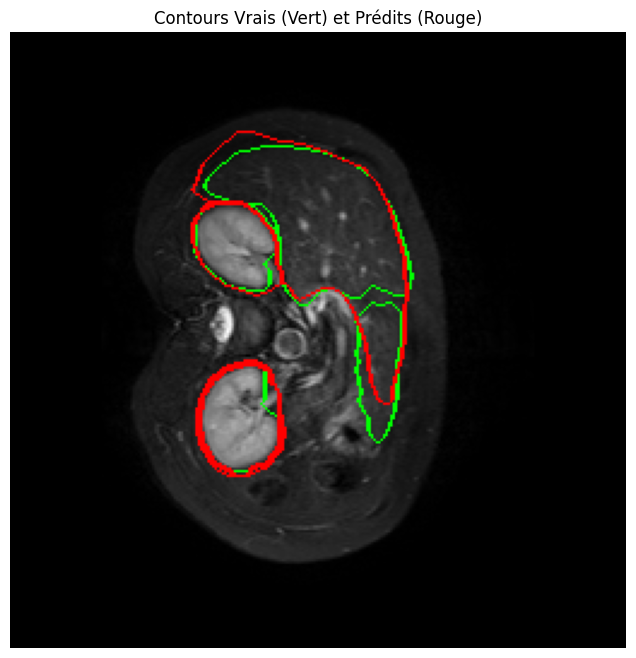

In [132]:
display_random_prediction(model, val_loader, device)

Matrice de confusion sans normalisation


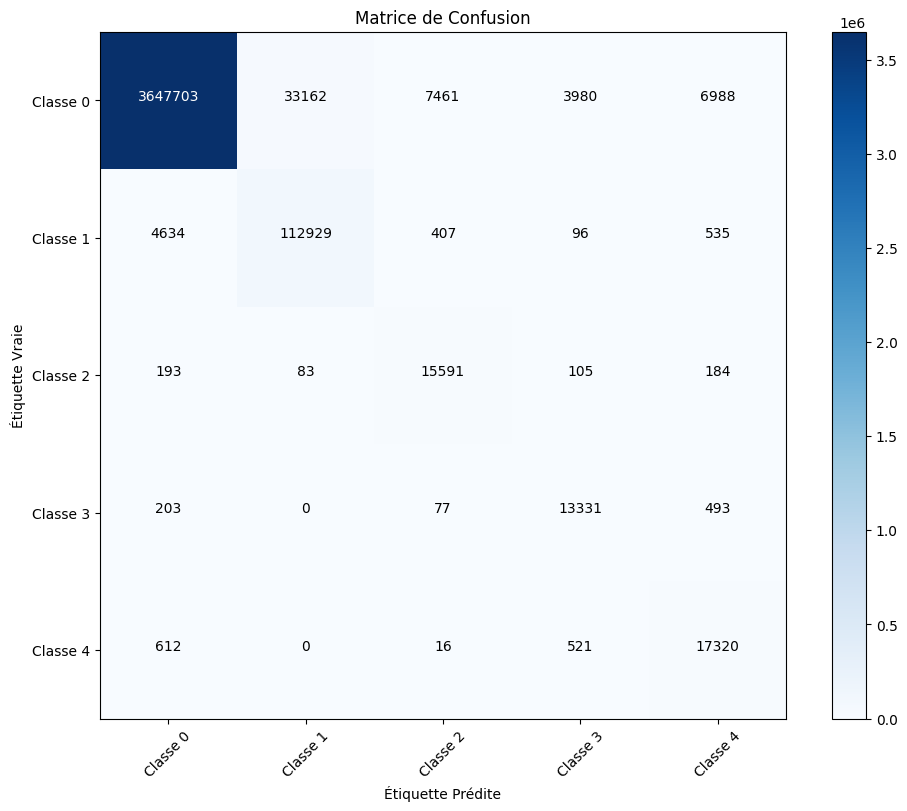

In [92]:
# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(cm, classes, normalize=False, title='Matrice de Confusion', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion sans normalisation')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Étiquette Vraie')
    plt.xlabel('Étiquette Prédite')

def evaluate_confusion_matrix(model, val_loader, device, num_classes=5):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for data, mask in val_loader:
            data = data.to(device)
            mask = mask.squeeze(1).to(device).long()  # Conversion explicite en entiers

            # Prédictions du modèle
            output = model(data)
            predicted_classes = torch.argmax(output, dim=1).long()  # Conversion explicite en entiers

            # Collecter les valeurs réelles et prédites
            y_true.extend(mask.cpu().numpy().flatten().astype(int))  # Conversion explicite en entiers
            y_pred.extend(predicted_classes.cpu().numpy().flatten().astype(int))  # Conversion explicite en entiers

    # Créer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    # Afficher la matrice de confusion
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cm, classes=[f'Classe {i}' for i in range(num_classes)])
    plt.show()

# Appeler la fonction pour évaluer et afficher la matrice de confusion
evaluate_confusion_matrix(model, val_loader, device)
